In [1]:
#import all the packages...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")
from dateutil import relativedelta
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import lightgbm as lgb
import datetime
from IPython.core.debugger import Pdb

In [2]:
df = pd.read_excel('data/Data.xlsx')
df=df[['Date','Key','Volume','avg_T','precipitation']]

In [3]:
df.columns

Index(['Date', 'Key', 'Volume', 'avg_T', 'precipitation'], dtype='object')

In [4]:
df.Date = pd.to_datetime(df.Date,format='%d-%m-%Y')
Brand_list = df.Key.unique()

In [5]:
df.dropna(inplace=True)

In [6]:
final = pd.DataFrame()

for brand_name in Brand_list:
    print(brand_name)
    brand_df = df.loc[df.Key == brand_name]
    #brand_df = bgt_transformation(brand_df)
    brand_df.set_index('Date',inplace=True)
    tmp = []
    forecast = pd.DataFrame()
    Actuals = pd.DataFrame()
    p = pd.DataFrame()
    k = pd.DataFrame()
#     brand_df = brand_df[:'2019-10-01']
    if len(brand_df)>12:
        train_start = datetime.date(2019, 3, 1)
        train_till = datetime.date(2019, 12, 1)
        Actuals_end = datetime.date(2019, 12, 1)
        train_date = train_start
        while train_date < train_till:
            test_date = train_date + relativedelta.relativedelta(months=1)
            dependent_colume = 'Volume'
            x = brand_df.drop(columns=[dependent_colume,'Key'])
            y = brand_df[[dependent_colume]]
            train_x = x[:train_date]
            train_y = y[:train_date][[dependent_colume]]
            test_x = x[test_date:]
            test_y = y[test_date:][[dependent_colume]]
            train_date = train_date + relativedelta.relativedelta(months=1)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': {'l2', 'l1'},
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.8,
                'bagging_freq': 5,
                'verbose': 0
            }
            
            try:
                # if brand_name == 'A':
                #     Pdb().set_trace()
                lgb_train = lgb.Dataset(train_x, train_y)
                gbm = lgb.train(params,lgb_train,num_boost_round=500)

        #         #forecast for next forecast period....
                if test_date > Actuals_end:
                    p = pd.DataFrame()
                    print(list(
                        gbm.predict(
                            test_x[test_date:],
                            num_iteration=gbm.best_iteration
                        )
                    ))
                    p["Forecast_values"] = list(gbm.predict(
                        test_x[test_date:],
                        num_iteration=gbm.best_iteration
                    ))
                    p.index = test_y[test_date:].index
                    p["Brand"] = \
                        str(brand_name) + str("_") + \
                            p.index.month.astype(str) + \
                                str("_")+p.index.year.astype(str)
            
                    
                    k = pd.DataFrame()
                    k = test_y[test_date:]
                    k.columns = ['Actual_values']
                    k.index = test_y[test_date:].index
                    k["Brand"] = str(brand_name) + str("_") + \
                        k.index.month.astype(str) + str("_") + \
                            k.index.year.astype(str)

                    break
                    
                forecast[
                    str(brand_name)+str('_')+str(test_date.month)+\
                        str("_")+str(test_date.year)
                ] = gbm.predict(
                    test_x[test_date:test_date],
                    num_iteration=gbm.best_iteration
                ).reshape(1,)

                Actuals[
                    str(brand_name)+str('_')+str(test_date.month)+\
                        str("_")+str(test_date.year)
                ] = test_y[test_date:test_date].values[0]
            
            except:
                continue
                
        if (len(forecast)>0 & len(Actuals>0)):
            forecast=forecast.T.reset_index()
            forecast.columns=["Brand","Forecast_values"]
            if(len(p)>0):
                forecast= pd.concat([forecast,p],axis=0)
            Actuals=Actuals.T.reset_index()
            Actuals.columns=["Brand","Actual_values"]
            if(len(k)>0):
                Actuals= pd.concat([Actuals,k],axis=0)
            brand_wise_merge = forecast.merge(Actuals,on="Brand",how="left")
            final = final.append(brand_wise_merge,ignore_index=True)
        else:
            print("doesn't match with LGBM")
    else:
        print("length does not match")

A
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [7]:
final.head(25)

Brand  Forecast_values  Actual_values
0    A_4_2019     1.273225e+06   1.526339e+06
1    A_5_2019     1.776704e+06   2.070232e+06
2    A_6_2019     1.809770e+06   2.367853e+06
3    A_7_2019     1.824944e+06   1.748441e+06
4    A_8_2019     1.842842e+06   1.965172e+06
5    A_9_2019     1.992928e+06   1.677322e+06
6   A_10_2019     1.327512e+06   1.228504e+06
7   A_11_2019     1.313835e+06   1.187562e+06
8   A_12_2019     1.392333e+06   1.196691e+06
9    B_4_2019     5.928434e+05   6.882605e+05
10   B_5_2019     8.040526e+05   9.298659e+05
11   B_6_2019     8.683047e+05   9.743226e+05
12   B_7_2019     8.754922e+05   8.918098e+05
13   B_8_2019     8.834556e+05   9.941879e+05
14   B_9_2019     8.246478e+05   7.750399e+05
15  B_10_2019     5.466673e+05   5.371221e+05
16  B_11_2019     5.938954e+05   5.069951e+05
17  B_12_2019     5.202024e+05   3.386888e+05
18   C_4_2019     9.618023e+05   9.226573e+05
19   C_5_2019     1.183511e+06   1.234498e+06
20   C_6_2019     1.469000e+06   1.358146e+06
21   C_7_2019     1.475954e+06   1.220493e+06
22   C_8_2019     1.476057e+06   1.448856e+06
23   C_9_2019     1.201689e+06   1.022206e+06
24  C_10_2019     7.725320e+05   6.396738e+05

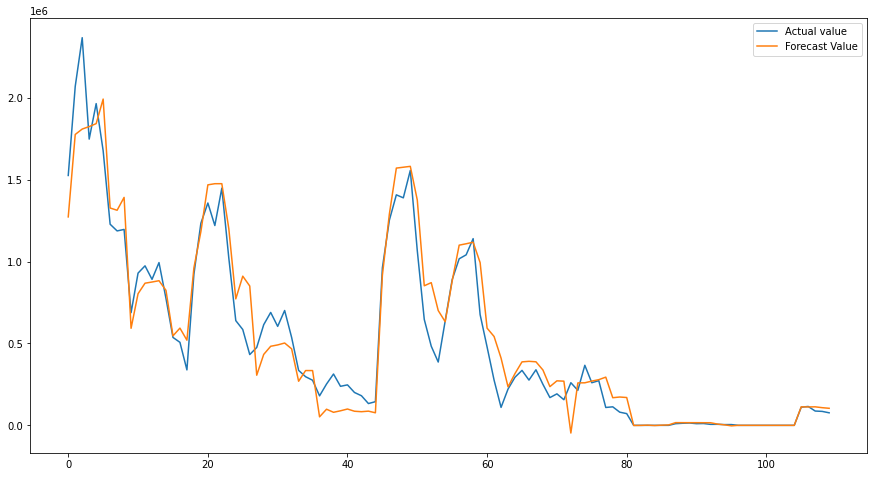

In [9]:
plt.figure(figsize=(15,8))
plt.plot(final.Actual_values,label='Actual value')
plt.plot(final.Forecast_values,label='Forecast Value')
plt.legend()
plt.show()

In [16]:
final[final.Brand.str.slice(0,1) == 'A']

Brand  Forecast_values  Actual_values
0   A_4_2019     1.273225e+06   1.526339e+06
1   A_5_2019     1.776704e+06   2.070232e+06
2   A_6_2019     1.809770e+06   2.367853e+06
3   A_7_2019     1.824944e+06   1.748441e+06
4   A_8_2019     1.842842e+06   1.965172e+06
5   A_9_2019     1.992928e+06   1.677322e+06
6  A_10_2019     1.327512e+06   1.228504e+06
7  A_11_2019     1.313835e+06   1.187562e+06
8  A_12_2019     1.392333e+06   1.196691e+06